In [1]:
%pylab inline
import pandas as pd
import sys
import gc
import lightgbm as lgb
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
FOLD=2

In [3]:
print FOLD

2


In [4]:
sys.path.insert(0,"../python/rrvf2017/")

In [5]:
from rrvf_data import   DataGen, normalize
import rrvf_data

In [6]:
def get_index(cols,columns):
    lst=[]
    for c in cols:
        lst.append(np.where(columns==c)[0][0])
    return np.array(lst)

In [7]:
def read_data(offset):
    columns,data=rrvf_data.read_data( offset,"../input/train_test_extb.npy.npz",with_l2=True)
    rawy=data[:,:,get_index(['visitors'],columns)[0]].copy()
    print len(columns),data.shape,rawy.shape    
    return columns,data,rawy

In [8]:
gc.collect()

7

In [9]:
#show_data(data,columns, 1,480, None)

In [10]:
#show_data2(data,columns)

# cv

In [11]:
n_reg_lookback=28

In [12]:
lag_cols=array(['visitor_ma28', 'visitor_ma56', 'visitor_ma14', 'visitor_ma112', 'visitor_ma224', 'visitor_sma8', 'visitor_sma4', 'visitor_sma3', 'visitor_sma16', 'visitor_sma2', 'visitor_ma4', 'visitor_ma2', 'visitors', 'visitor_lag7', 'visitor_lag14', 'visitor_lag28', 'visitor_lag91', 'visitor_lag182', 'visitor_lag364', 'geo2_visitors_mean', 'all_count_y1', 'geo1_visitors_mean', 'all_count_y3', 'day_of_week_visitors_mean', 'station_count_y2', 'all_count_y5'])
len(lag_cols)

26

In [13]:
def make_ondate_train_test(ondate_cols,data,columns):
    ondate_train_test=np.round(data[:,:,get_index(ondate_cols,columns)].copy(),2)
    ondate_train_test=normalize(ondate_train_test)
    v=np.zeros_like(ondate_train_test[:,:,0])
    for i in range(v.shape[0]): v[i]=i
    #ondate_train_test = np.concatenate([np.expand_dims(v,-1),ondate_train_test],axis=-1)
    print ondate_train_test.shape
    return ondate_train_test

In [14]:
ondate_cols =array(['const_one', 'visitor_lag91', 'visitor_lag182', 'TMIN', 'holiday', 'TAVG','f_t',
                    'weekday6', 'weekday5', 'weekday4', 'weekday3', 'weekday2', 'weekday1', 'weekday0',
                    'rv_sum', 'rv_mean', 'rv_gap_mean', 'rv_gap_weighted_mean',
                    '3003nb_conv_fold{}_False_d478.pkl', '3005_rf_fold{}_False_d478.pkl', '3001eb_lgb_fold{}_True_d478.pkl', '3002nb_lstm_fold{}_False_d478.pkl', '3000eb_ridge_fold{}_True_d478.pkl', '3002_lstm_fold{}_False_d478.pkl', '3006_xgb_fold{}_False_d478.pkl', '3003_conv_fold{}_False_d478.pkl', '3000_ridge_fold{}_False_d478.pkl', '3001_lgb_fold{}_False_d478.pkl'                    
                   ])

In [15]:
def make_lag_train_test(lag_cols,data,columns):
    lag_train_test=data[:,:,get_index(lag_cols,columns)].copy()
    lag_train_test=normalize(lag_train_test)
    print lag_train_test.shape
    return lag_train_test

In [16]:
from sklearn.model_selection import GridSearchCV,ParameterGrid,ParameterSampler
from sklearn.metrics import  make_scorer
from multiprocessing import Pool

In [17]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation, InputLayer, Dropout,BatchNormalization
from keras import metrics,backend,regularizers, backend as K, losses
import keras
import tensorflow as tf
from keras.engine.topology import Layer
from keras.backend.tensorflow_backend import set_session
print K.floatx()

Using TensorFlow backend.


float32


In [18]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
#config.intra_op_parallelism_threads=8
#config.inter_op_parallelism_threads=8
set_session(tf.Session(config=config))

# time split

In [19]:
import cPickle as pickle
indexes=rrvf_data.get_train_valid_indexes()

In [20]:
param_grid={
            'metric':['mean_squared_error' ],
            'loss':['mean_squared_error'],
            "patience":[5],
            "activation":['relu'],    
            "l2":[1e-6,0],
            'batch_normalization': [False],
            "optimizer":['adam','adam','adagrad']
           }
parameters=list(ParameterGrid(param_grid))
parameter=parameters[0]
len(parameters),parameter

(6,
 {'activation': 'relu',
  'batch_normalization': False,
  'l2': 1e-06,
  'loss': 'mean_squared_error',
  'metric': 'mean_squared_error',
  'optimizer': 'adam',
  'patience': 5})

In [21]:
import rrvf_model as  rrvf
reload(rrvf)

<module 'rrvf_model' from '../python/rrvf2017/rrvf_model.pyc'>

In [22]:
from sklearn.metrics import mean_squared_error

In [23]:
def predict_test(self,test_gen):
    X, y, mask,w =test_gen.get_train()
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, X)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), w.shape
    return yy_pred, w, y, mask,X
def g(a,test_gen):
    result=predict_test(a,test_gen)
    df=pd.DataFrame({'y':result[2][:,0]})
    df['pred']=result[0][:,0]
    df['dayidx']=result[1][:,1]
    df=df.loc[df['y']>0]
    df['error']=df['y']-df['pred']
    df['error2']=df['error']**2
    df['day']=pd.to_datetime(rrvf_data.idx_to_date(df['dayidx'])).map(lambda u: u.weekday+1)
    df2=df.groupby("dayidx").mean() 
    df2['date']=pd.to_datetime(rrvf_data.idx_to_date(df2.index)).map(lambda u: u.date())
    display(df2)
    print  df2['error2'].mean()
    return  df2['error2'].mean()

PRED_DATE=478

def h(self,train_gen):
    Xdict,_,dataidx,_=train_gen.get_by_t2(day=PRED_DATE)
    filenames = self.best_epoch
    aa = rrvf.make_pred(filenames, Xdict)
    aa = np.array(aa)
    yy_pred = np.sum(aa * self.get_weights().reshape([-1, 1, 1]), 0)
    print yy_pred.shape, np.mean(yy_pred), 
    return yy_pred, dataidx


In [24]:
EXCLUDE_HARD=False

import rrvf_model as rrvf
import rrvf_data
def _run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    batchsize=128
    ondate_train_test=make_ondate_train_test(ondate_cols,data,columns)
    lag_train_test = make_lag_train_test(lag_cols,data,columns)
    train_gen=DataGen(lag_train_test,ondate_train_test, rawy,n_reg_lookback+1, 478,# 478-1*7-39-n_offset, 
                      batchsize=batchsize,valid_split=0.1, indexes=index,lookforward_offset=n_offset,
                      exclude_hard=EXCLUDE_HARD,                      
                  lookback1=n_reg_lookback,  lookforward=n_lookforward)
    valid_gen=None
    test_gen=DataGen(lag_train_test,ondate_train_test, rawy,478-1*7-n_offset,478, lookforward_offset=n_offset,
                     batchsize=batchsize,lookback1=n_reg_lookback, lookforward=n_lookforward)
    print train_gen.train_steps_per_epoch
    print 0 if valid_gen is None else valid_gen.train_steps_per_epoch
    
    lag_input_dim=lag_train_test.shape[-1]
    ondate_input_dim=ondate_train_test.shape[-1]
    print lag_input_dim,ondate_input_dim,(n_lookforward,ondate_input_dim)
    backend.clear_session()
    set_session(tf.Session(config=config))   
    a=rrvf.KerasModel("testlstm_l2_{}".format(FOLD), n_lookforward=n_lookforward,n_reg_lookback=n_reg_lookback,
                      ondate_input_dim=ondate_input_dim, lag_input_dim=lag_input_dim, n_offset=n_offset,
                      max_epoch=100, use_output_exp=False,use_dropout=False,model_type='conv',
                      params=parameter)
    a._make_model()
    print a.params
    print a.model.count_params()
    a.fit(train_gen,valid_gen)
    if a.model.abnormal_stop:
        return np.inf,None,None
    valid_loss,validy,validpred,valididx=a.eval_valid()
    print valid_loss
    g(a,test_gen)
    pred478=h(a,train_gen)
    return valid_loss,(validy,valididx,validpred),pred478



def run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset):
    while 1:
        ret=_run_once(columns,data,rawy,index, ondate_cols,lag_cols,n_lookforward,n_offset)
        if ret[0]<1:
            return ret
        else:
            print "bad init,try again."
        

In [25]:
def MSE(a,b):
    idx= np.isnan(a) | np.isnan(b)
    a=a[~idx]
    b=b[~idx]
    #print np.mean(~idx)
    return np.mean((a-b)**2)
    return mean_squared_error(a,b)

In [26]:
j=FOLD
validpreds={}
for offset in range(1,40):
    print "\n\n",offset
    columns,data,rawy=read_data(offset=offset)    
    _,validpred,pred478=run_once(columns,data,rawy,indexes[j],ondate_cols,lag_cols,n_lookforward=offset,n_offset=offset-1)
    validpreds[offset]=[validpred,pred478]
    pickle.dump(validpreds,   open('l2_3003_conv_fold{}_{}_d{}.pkl'.format(j, EXCLUDE_HARD, PRED_DATE) ,'wb'))



1
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 5803 records out of 5803 records
no valid set
1537
0
26 28 (1, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2820 - total_loss: 0.2820 - reg_loss: 0.2820 - val_loss: 0.2725 - val_total_loss: 0.2725 - val_reg_loss: 0.2725
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/step - loss: 0.2584 - total_loss: 0.2584 - reg_loss: 0.2584 - val_loss:

y      pred     error    error2  day        date
dayidx                                                         
471     2.929110  2.901898  0.027212  0.237254    7  2017-04-16
472     2.507290  2.528093 -0.020803  0.230861    1  2017-04-17
473     2.661330  2.638715  0.022615  0.251023    2  2017-04-18
474     2.754815  2.769665 -0.014850  0.207758    3  2017-04-19
475     2.713762  2.725687 -0.011925  0.235429    4  2017-04-20
476     2.999000  3.000737 -0.001737  0.155131    5  2017-04-21
477     3.075529  3.088657 -0.013128  0.189110    6  2017-04-22

0.215223798724
best_epochs [4, 5, 8, 6, 7]
(829, 1) 2.66305918132 

2
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 6632 records out of 6632 records
no valid set
1537
0
26 28 (2, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.2776 - total_loss: 0.2776 - reg_loss: 0.2776 - val_loss: 0.2555 - val_total_loss: 0.2555 - val_reg_loss: 0.2555
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/step 

y      pred     error    error2  day        date
dayidx                                                         
470     2.929110  2.917462  0.011648  0.291188    6  2017-04-15
471     2.507290  2.595901 -0.088610  0.440160    7  2017-04-16
472     2.661330  2.736457 -0.075128  0.364546    1  2017-04-17
473     2.754815  2.783239 -0.028424  0.258796    2  2017-04-18
474     2.713762  2.746868 -0.033106  0.298927    3  2017-04-19
475     2.999000  2.997702  0.001298  0.206065    4  2017-04-20
476     3.075529  3.081816 -0.006287  0.226906    5  2017-04-21

0.298083746097
best_epochs [3, 4, 6, 8, 5]
(829, 1) 2.50908341544 

3
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 7461 records out of 7461 records
no valid set
1537
0
26 28 (3, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 15ms/step - loss: 0.2820 - total_loss: 0.2820 - reg_loss: 0.2820 - val_loss: 0.2620 - val_total_loss: 0.2620 - val_reg_loss: 0.2620
Epoch 2/100
1537/1537 [==============================] - 23s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
469     2.929110  2.908498  0.020611  0.264945    5  2017-04-14
470     2.507290  2.567920 -0.060629  0.313244    6  2017-04-15
471     2.661330  2.720464 -0.059134  0.413973    7  2017-04-16
472     2.754815  2.797806 -0.042992  0.345117    1  2017-04-17
473     2.713762  2.759238 -0.045476  0.318943    2  2017-04-18
474     2.999000  3.002135 -0.003135  0.193493    3  2017-04-19
475     3.075529  3.094310 -0.018781  0.260597    4  2017-04-20

0.301473199337
best_epochs [7, 6, 5, 3, 2]
(829, 1) 2.65217085678 

4
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 8290 records out of 8290 records
no valid set
1537
0
26 28 (4, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2825 - total_loss: 0.2825 - reg_loss: 0.2825 - val_loss: 0.2583 - val_total_loss: 0.2583 - val_reg_loss: 0.2583
Epoch 2/100
1537/1537 [==============================] - 24s 15ms/step 

y      pred     error    error2  day        date
dayidx                                                         
468     2.929110  2.903385  0.025725  0.320925    4  2017-04-13
469     2.507290  2.523670 -0.016379  0.267652    5  2017-04-14
470     2.661330  2.680190 -0.018860  0.300213    6  2017-04-15
471     2.754815  2.722592  0.032223  0.369485    7  2017-04-16
472     2.713762  2.768150 -0.054388  0.354499    1  2017-04-17
473     2.999000  2.981921  0.017079  0.215214    2  2017-04-18
474     3.075529  3.043995  0.031534  0.261497    3  2017-04-19

0.298497926838
best_epochs [4, 5, 3, 7, 9]
(829, 1) 2.7105103876 

5
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 14.8043
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 9119 records out of 9119 records
no valid set
1537
0
26 28 (5, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2858 - total_loss: 0.2858 - reg_loss: 0.2858 - val_loss: 0.2701 - val_total_loss: 0.2701 - val_reg_loss: 0.2701
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/step -

y      pred     error    error2  day        date
dayidx                                                         
467     2.929110  2.888422  0.040687  0.348879    3  2017-04-12
468     2.507290  2.556545 -0.049254  0.295135    4  2017-04-13
469     2.661330  2.657112  0.004218  0.287968    5  2017-04-14
470     2.754815  2.745894  0.008921  0.259575    6  2017-04-15
471     2.713762  2.685936  0.027825  0.398826    7  2017-04-16
472     2.999000  2.964601  0.034399  0.285778    1  2017-04-17
473     3.075529  3.042183  0.033346  0.272933    2  2017-04-18

0.307013323216
best_epochs [4, 5, 3, 9, 8]
(829, 1) 2.69979173674 

6
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 15.1334
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 9948 records out of 9948 records
no valid set
1537
0
26 28 (6, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2997 - total_loss: 0.2997 - reg_loss: 0.2997 - val_loss: 0.2613 - val_total_loss: 0.2613 - val_reg_loss: 0.2613
Epoch 2/100
1537/1537 [==============================] - 21s 14ms/step 

y      pred     error    error2  day        date
dayidx                                                         
466     2.929110  2.879971  0.049139  0.342655    2  2017-04-11
467     2.507290  2.560141 -0.052851  0.323713    3  2017-04-12
468     2.661330  2.694076 -0.032747  0.310730    4  2017-04-13
469     2.754815  2.746065  0.008750  0.241124    5  2017-04-14
470     2.713762  2.714319 -0.000557  0.283591    6  2017-04-15
471     2.999000  2.908898  0.090101  0.325921    7  2017-04-16
472     3.075529  3.031704  0.043825  0.334373    1  2017-04-17

0.308872417045
best_epochs [7, 5, 6, 4, 2]
(829, 1) 2.98929180197 

7
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 16.3101
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 10777 records out of 10777 records
no valid set
1537
0
26 28 (7, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2854 - total_loss: 0.2854 - reg_loss: 0.2854 - val_loss: 0.2563 - val_total_loss: 0.2563 - val_reg_loss: 0.2563
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
465     2.929110  2.891931  0.037179  0.382198    1  2017-04-10
466     2.507290  2.569876 -0.062586  0.321713    2  2017-04-11
467     2.661330  2.715039 -0.053710  0.329680    3  2017-04-12
468     2.754815  2.773489 -0.018674  0.265735    4  2017-04-13
469     2.713762  2.738018 -0.024257  0.276752    5  2017-04-14
470     2.999000  3.001476 -0.002476  0.205621    6  2017-04-15
471     3.075529  3.091623 -0.016094  0.332839    7  2017-04-16

0.302076804403
best_epochs [6, 3, 4, 8, 2]
(829, 1) 3.01778082263 

8
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 17.5743
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 11606 records out of 11606 records
no valid set
1537
0
26 28 (8, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 15ms/step - loss: 0.2811 - total_loss: 0.2811 - reg_loss: 0.2811 - val_loss: 0.2927 - val_total_loss: 0.2927 - val_reg_loss: 0.2927
Epoch 2/100
1537/1537 [==============================] - 21s 14ms/ste

y      pred     error    error2  day        date
dayidx                                                         
464     2.929110  2.967891 -0.038781  0.357543    7  2017-04-09
465     2.507290  2.600830 -0.093540  0.340128    1  2017-04-10
466     2.661330  2.694365 -0.033035  0.312118    2  2017-04-11
467     2.754815  2.800173 -0.045358  0.291712    3  2017-04-12
468     2.713762  2.740504 -0.026742  0.294405    4  2017-04-13
469     2.999000  2.976246  0.022754  0.176982    5  2017-04-14
470     3.075529  3.105294 -0.029764  0.233203    6  2017-04-15

0.286584377339
best_epochs [3, 6, 8, 7, 5]
(829, 1) 2.75828288992 

9
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 18.8065
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 12435 records out of 12435 records
no valid set
1537
0
26 28 (9, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2889 - total_loss: 0.2889 - reg_loss: 0.2889 - val_loss: 0.2617 - val_total_loss: 0.2617 - val_reg_loss: 0.2617
Epoch 2/100
1537/1537 [==============================] - 21s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
463     2.929110  2.923767  0.005343  0.284706    6  2017-04-08
464     2.507290  2.629826 -0.122535  0.441638    7  2017-04-09
465     2.661330  2.703980 -0.042650  0.384159    1  2017-04-10
466     2.754815  2.743348  0.011467  0.280168    2  2017-04-11
467     2.713762  2.751518 -0.037756  0.324047    3  2017-04-12
468     2.999000  2.985350  0.013650  0.210606    4  2017-04-13
469     3.075529  3.081492 -0.005962  0.230934    5  2017-04-14

0.308036838956
best_epochs [6, 5, 7, 1, 8]
(829, 1) 2.61459450951 

10
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 19.9265
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 13264 records out of 13264 records
no valid set
1537
0
26 28 (10, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2957 - total_loss: 0.2957 - reg_loss: 0.2957 - val_loss: 0.2706 - val_total_loss: 0.2706 - val_reg_loss: 0.2706
Epoch 2/100
1537/1537 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
462     2.929110  2.911765  0.017345  0.278767    5  2017-04-07
463     2.507290  2.560819 -0.053529  0.298429    6  2017-04-08
464     2.661330  2.700688 -0.039359  0.413528    7  2017-04-09
465     2.754815  2.801278 -0.046463  0.345766    1  2017-04-10
466     2.713762  2.759627 -0.045865  0.310032    2  2017-04-11
467     2.999000  3.000128 -0.001128  0.212899    3  2017-04-12
468     3.075529  3.072766  0.002764  0.254560    4  2017-04-13

0.301997146525
best_epochs [4, 3, 6, 9, 5]
(829, 1) 2.66856823092 

11
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 21.0577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 14093 records out of 14093 records
no valid set
1537
0
26 28 (11, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2931 - total_loss: 0.2931 - reg_loss: 0.2931 - val_loss: 0.2686 - val_total_loss: 0.2686 - val_reg_loss: 0.2686
Epoch 2/100
1537/1537 [==============================] - 21s 14ms/s

y      pred     error    error2  day        date
dayidx                                                         
461     2.929110  2.907682  0.021427  0.322910    4  2017-04-06
462     2.507290  2.571247 -0.063956  0.275925    5  2017-04-07
463     2.661330  2.684446 -0.023116  0.313960    6  2017-04-08
464     2.754815  2.768721 -0.013906  0.387473    7  2017-04-09
465     2.713762  2.795533 -0.081771  0.379798    1  2017-04-10
466     2.999000  2.996325  0.002675  0.233008    2  2017-04-11
467     3.075529  3.056748  0.018781  0.272040    3  2017-04-12

0.312159202604
best_epochs [5, 7, 4, 2, 8]
(829, 1) 3.02932774721 

12
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 22.1151
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 14922 records out of 14922 records
no valid set
1537
0
26 28 (12, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3031 - total_loss: 0.3031 - reg_loss: 0.3031 - val_loss: 0.2722 - val_total_loss: 0.2722 - val_reg_loss: 0.2722
Epoch 2/100
1537/1537 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
460     2.929110  2.816220  0.112890  0.344101    3  2017-04-05
461     2.507290  2.527673 -0.020382  0.288231    4  2017-04-06
462     2.661330  2.647243  0.014087  0.306212    5  2017-04-07
463     2.754815  2.704977  0.049838  0.262833    6  2017-04-08
464     2.713762  2.655899  0.057863  0.391576    7  2017-04-09
465     2.999000  2.924292  0.074708  0.263240    1  2017-04-10
466     3.075529  3.009744  0.065785  0.270003    2  2017-04-11

0.303742365239
best_epochs [4, 6, 3, 5, 7]
(829, 1) 2.96237930808 

13
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 23.1552
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 15751 records out of 15751 records
no valid set
1537
0
26 28 (13, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2974 - total_loss: 0.2974 - reg_loss: 0.2974 - val_loss: 0.2694 - val_total_loss: 0.2694 - val_reg_loss: 0.2694
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
459     2.929110  2.891710  0.037400  0.355367    2  2017-04-04
460     2.507290  2.574331 -0.067040  0.298492    3  2017-04-05
461     2.661330  2.693368 -0.032038  0.311073    4  2017-04-06
462     2.754815  2.742720  0.012095  0.263973    5  2017-04-07
463     2.713762  2.720038 -0.006276  0.284046    6  2017-04-08
464     2.999000  2.883694  0.115306  0.346831    7  2017-04-09
465     3.075529  3.014010  0.061519  0.323903    1  2017-04-10

0.311954986692
best_epochs [6, 4, 7, 8, 5]
(829, 1) 3.07895866615 

14
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 24.2264
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 16580 records out of 16580 records
no valid set
1537
0
26 28 (14, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.2932 - total_loss: 0.2932 - reg_loss: 0.2932 - val_loss: 0.2870 - val_total_loss: 0.2870 - val_reg_loss: 0.2870
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
458     2.929110  2.916815  0.012295  0.400320    1  2017-04-03
459     2.507290  2.596698 -0.089407  0.299023    2  2017-04-04
460     2.661330  2.714058 -0.052728  0.336086    3  2017-04-05
461     2.754815  2.760392 -0.005578  0.280602    4  2017-04-06
462     2.713762  2.772576 -0.058814  0.290994    5  2017-04-07
463     2.999000  2.991279  0.007721  0.198117    6  2017-04-08
464     3.075529  3.091169 -0.015640  0.323558    7  2017-04-09

0.304100008686
best_epochs [6, 4, 3, 5, 7]
(829, 1) 3.10636736959 

15
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 25.3577
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 17409 records out of 17409 records
no valid set
1537
0
26 28 (15, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.2892 - total_loss: 0.2892 - reg_loss: 0.2892 - val_loss: 0.2627 - val_total_loss: 0.2627 - val_reg_loss: 0.2627
Epoch 2/100
1537/1537 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
457     2.929110  2.992469 -0.063359  0.361248    7  2017-04-02
458     2.507290  2.606772 -0.099482  0.339102    1  2017-04-03
459     2.661330  2.681881 -0.020551  0.310564    2  2017-04-04
460     2.754815  2.748889  0.005926  0.274327    3  2017-04-05
461     2.713762  2.753555 -0.039794  0.294133    4  2017-04-06
462     2.999000  2.971710  0.027290  0.176901    5  2017-04-07
463     3.075529  3.060900  0.014629  0.220391    6  2017-04-08

0.282380861266
best_epochs [4, 7, 3, 8, 1]
(829, 1) 2.77107047754 

16
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 26.4659
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 18238 records out of 18238 records
no valid set
1537
0
26 28 (16, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.2967 - total_loss: 0.2967 - reg_loss: 0.2967 - val_loss: 0.2715 - val_total_loss: 0.2715 - val_reg_loss: 0.2715
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
456     2.929110  2.876726  0.052384  0.295567    6  2017-04-01
457     2.507290  2.627063 -0.119773  0.445166    7  2017-04-02
458     2.661330  2.721497 -0.060167  0.378274    1  2017-04-03
459     2.754815  2.749958  0.004857  0.280430    2  2017-04-04
460     2.713762  2.716804 -0.003043  0.322018    3  2017-04-05
461     2.999000  2.992734  0.006265  0.214103    4  2017-04-06
462     3.075529  3.070302  0.005227  0.225948    5  2017-04-07

0.308786750174
best_epochs [3, 5, 4, 2, 7]
(829, 1) 2.58447466969 

17
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 27.6058
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 19067 records out of 19067 records
no valid set
1537
0
26 28 (17, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.2993 - total_loss: 0.2993 - reg_loss: 0.2993 - val_loss: 0.2682 - val_total_loss: 0.2682 - val_reg_loss: 0.2682
Epoch 2/100
1537/1537 [==============================] - 21s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
455     2.929110  2.909820  0.019290  0.291216    5  2017-03-31
456     2.507290  2.563070 -0.055780  0.291652    6  2017-04-01
457     2.661330  2.700236 -0.038906  0.413707    7  2017-04-02
458     2.754815  2.791788 -0.036973  0.356362    1  2017-04-03
459     2.713762  2.758602 -0.044840  0.332332    2  2017-04-04
460     2.999000  2.996691  0.002309  0.223977    3  2017-04-05
461     3.075529  3.053362  0.022167  0.256719    4  2017-04-06

0.309423688775
best_epochs [4, 3, 6, 5, 7]
(829, 1) 2.63635237235 

18
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 28.7513
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 19896 records out of 19896 records
no valid set
1537
0
26 28 (18, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3009 - total_loss: 0.3009 - reg_loss: 0.3009 - val_loss: 0.2817 - val_total_loss: 0.2817 - val_reg_loss: 0.2817
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
454     2.929110  2.895728  0.033382  0.329098    4  2017-03-30
455     2.507290  2.533853 -0.026563  0.263181    5  2017-03-31
456     2.661330  2.662063 -0.000733  0.314302    6  2017-04-01
457     2.754815  2.702384  0.052431  0.365244    7  2017-04-02
458     2.713762  2.753162 -0.039401  0.344257    1  2017-04-03
459     2.999000  2.977999  0.021001  0.227574    2  2017-04-04
460     3.075529  3.011821  0.063708  0.267320    3  2017-04-05

0.301568005251
best_epochs [3, 5, 7, 4, 2]
(829, 1) 2.74963772294 

19
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 29.7986
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 20725 records out of 20725 records
no valid set
1537
0
26 28 (19, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.3051 - total_loss: 0.3051 - reg_loss: 0.3051 - val_loss: 0.2729 - val_total_loss: 0.2729 - val_reg_loss: 0.2729
Epoch 2/100
1537/1537 [==============================] - 23s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
453     2.929110  2.851169  0.077941  0.348169    3  2017-03-29
454     2.507290  2.556976 -0.049685  0.310343    4  2017-03-30
455     2.661330  2.663042 -0.001713  0.292198    5  2017-03-31
456     2.754815  2.731810  0.023005  0.269735    6  2017-04-01
457     2.713762  2.709686  0.004076  0.393688    7  2017-04-02
458     2.999000  2.946154  0.052846  0.261896    1  2017-04-03
459     3.075529  3.017491  0.058038  0.272355    2  2017-04-04

0.306912154265
best_epochs [4, 6, 2, 8, 5]
(829, 1) 2.72513784065 

20
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 30.7963
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 21554 records out of 21554 records
no valid set
1537
0
26 28 (20, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.3102 - total_loss: 0.3102 - reg_loss: 0.3102 - val_loss: 0.2736 - val_total_loss: 0.2736 - val_reg_loss: 0.2736
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
452     2.929110  2.862530  0.066580  0.363848    2  2017-03-28
453     2.507290  2.560119 -0.052828  0.309340    3  2017-03-29
454     2.661330  2.695584 -0.034254  0.331091    4  2017-03-30
455     2.754815  2.710235  0.044579  0.254875    5  2017-03-31
456     2.713762  2.718784 -0.005022  0.289579    6  2017-04-01
457     2.999000  2.888343  0.110657  0.343934    7  2017-04-02
458     3.075529  3.010245  0.065284  0.301507    1  2017-04-03

0.313453330042
best_epochs [7, 3, 6, 9, 4]
(829, 1) 2.92468491766 

21
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 31.7929
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 22383 records out of 22383 records
no valid set
1537
0
26 28 (21, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.2991 - total_loss: 0.2991 - reg_loss: 0.2991 - val_loss: 0.2697 - val_total_loss: 0.2697 - val_reg_loss: 0.2697
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
451     2.929110  2.900277  0.028833  0.379118    1  2017-03-27
452     2.507290  2.559308 -0.052018  0.310425    2  2017-03-28
453     2.661330  2.708938 -0.047609  0.336998    3  2017-03-29
454     2.754815  2.755027 -0.000212  0.284409    4  2017-03-30
455     2.713762  2.711637  0.002124  0.270693    5  2017-03-31
456     2.999000  2.973690  0.025309  0.213826    6  2017-04-01
457     3.075529  3.056942  0.018587  0.316019    7  2017-04-02

0.30164106945
best_epochs [5, 4, 6, 2, 3]
(829, 1) 3.03207478469 

22
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 32.871
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 23212 records out of 23212 records
no valid set
1537
0
26 28 (22, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.2960 - total_loss: 0.2960 - reg_loss: 0.2960 - val_loss: 0.2894 - val_total_loss: 0.2894 - val_reg_loss: 0.2894
Epoch 2/100
1537/1537 [==============================] - 24s 15ms/ste

y      pred     error    error2  day        date
dayidx                                                         
450     2.929110  2.966224 -0.037114  0.360243    7  2017-03-26
451     2.507290  2.559448 -0.052158  0.328078    1  2017-03-27
452     2.661330  2.698367 -0.037037  0.307903    2  2017-03-28
453     2.754815  2.783040 -0.028225  0.288129    3  2017-03-29
454     2.713762  2.764431 -0.050669  0.327429    4  2017-03-30
455     2.999000  2.974201  0.024798  0.198643    5  2017-03-31
456     3.075529  3.062790  0.012739  0.222679    6  2017-04-01

0.290443465686
best_epochs [4, 3, 7, 6, 8]
(829, 1) 2.75644839375 

23
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 33.9745
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 24041 records out of 24041 records
no valid set
1537
0
26 28 (23, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.3019 - total_loss: 0.3019 - reg_loss: 0.3019 - val_loss: 0.2912 - val_total_loss: 0.2912 - val_reg_loss: 0.2912
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
449     2.929110  2.933727 -0.004617  0.307653    6  2017-03-25
450     2.507290  2.605923 -0.098632  0.439424    7  2017-03-26
451     2.661330  2.719278 -0.057948  0.363829    1  2017-03-27
452     2.754815  2.738639  0.016176  0.282488    2  2017-03-28
453     2.713762  2.734310 -0.020549  0.319161    3  2017-03-29
454     2.999000  2.987765  0.011234  0.215701    4  2017-03-30
455     3.075529  3.078599 -0.003070  0.208526    5  2017-03-31

0.305254638673
best_epochs [4, 3, 5, 6, 2]
(829, 1) 2.46883457134 

24
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 35.2084
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 24870 records out of 24870 records
no valid set
1537
0
26 28 (24, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3046 - total_loss: 0.3046 - reg_loss: 0.3046 - val_loss: 0.2776 - val_total_loss: 0.2776 - val_reg_loss: 0.2776
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
448     2.929110  2.930718 -0.001608  0.295496    5  2017-03-24
449     2.507290  2.509806 -0.002516  0.292789    6  2017-03-25
450     2.661330  2.704791 -0.043461  0.425828    7  2017-03-26
451     2.754815  2.771748 -0.016934  0.342501    1  2017-03-27
452     2.713762  2.780030 -0.066268  0.314246    2  2017-03-28
453     2.999000  2.993980  0.005020  0.218372    3  2017-03-29
454     3.075529  3.043177  0.032352  0.244494    4  2017-03-30

0.304818061174
best_epochs [6, 5, 8, 2, 7]
(829, 1) 2.61030347725 

25
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 36.3351
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 25699 records out of 25699 records
no valid set
1537
0
26 28 (25, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3074 - total_loss: 0.3074 - reg_loss: 0.3074 - val_loss: 0.2752 - val_total_loss: 0.2752 - val_reg_loss: 0.2752
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
447     2.929110  2.925918  0.003191  0.332834    4  2017-03-23
448     2.507290  2.516864 -0.009573  0.281878    5  2017-03-24
449     2.661330  2.669297 -0.007967  0.305471    6  2017-03-25
450     2.754815  2.708051  0.046764  0.390030    7  2017-03-26
451     2.713762  2.760238 -0.046476  0.360751    1  2017-03-27
452     2.999000  2.980249  0.018751  0.221567    2  2017-03-28
453     3.075529  3.006166  0.069364  0.278719    3  2017-03-29

0.310178815636
best_epochs [3, 4, 6, 7, 8]
(829, 1) 2.6741329384 

26
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 37.3741
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 26528 records out of 26528 records
no valid set
1537
0
26 28 (26, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3085 - total_loss: 0.3085 - reg_loss: 0.3085 - val_loss: 0.2756 - val_total_loss: 0.2756 - val_reg_loss: 0.2756
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
446     2.929110  2.874539  0.054571  0.376876    3  2017-03-22
447     2.507290  2.565370 -0.058080  0.310117    4  2017-03-23
448     2.661330  2.693846 -0.032517  0.307947    5  2017-03-24
449     2.754815  2.723763  0.031052  0.262988    6  2017-03-25
450     2.713762  2.697387  0.016375  0.388543    7  2017-03-26
451     2.999000  2.982938  0.016062  0.263221    1  2017-03-27
452     3.075529  3.050592  0.024938  0.286071    2  2017-03-28

0.313680664979
best_epochs [3, 5, 6, 4, 7]
(829, 1) 2.73052136354 

27
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 38.4506
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 27357 records out of 27357 records
no valid set
1537
0
26 28 (27, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3058 - total_loss: 0.3058 - reg_loss: 0.3058 - val_loss: 0.2757 - val_total_loss: 0.2757 - val_reg_loss: 0.2757
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
445     2.929110  2.835301  0.093809  0.388055    2  2017-03-21
446     2.507290  2.579682 -0.072392  0.302105    3  2017-03-22
447     2.661330  2.690203 -0.028873  0.325070    4  2017-03-23
448     2.754815  2.742332  0.012483  0.277351    5  2017-03-24
449     2.713762  2.773188 -0.059427  0.297203    6  2017-03-25
450     2.999000  2.911086  0.087914  0.342757    7  2017-03-26
451     3.075529  3.034578  0.040951  0.307934    1  2017-03-27

0.320067838394
best_epochs [4, 5, 7, 3, 2]
(829, 1) 2.96966392777 

28
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 39.4798
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 28186 records out of 28186 records
no valid set
1537
0
26 28 (28, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3012 - total_loss: 0.3012 - reg_loss: 0.3012 - val_loss: 0.2780 - val_total_loss: 0.2780 - val_reg_loss: 0.2780
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
444     2.929110  3.037391 -0.108281  0.434311    1  2017-03-20
445     2.507290  2.585139 -0.077849  0.351289    2  2017-03-21
446     2.661330  2.706976 -0.045647  0.327977    3  2017-03-22
447     2.754815  2.756840 -0.002025  0.282102    4  2017-03-23
448     2.713762  2.714085 -0.000324  0.300826    5  2017-03-24
449     2.999000  2.990073  0.008927  0.209741    6  2017-03-25
450     3.075529  3.102568 -0.027039  0.341884    7  2017-03-26

0.321161504411
best_epochs [2, 5, 3, 4, 6]
(829, 1) 3.12976301613 

29
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 40.7934
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 29015 records out of 29015 records
no valid set
1537
0
26 28 (29, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 20s 13ms/step - loss: 0.2997 - total_loss: 0.2997 - reg_loss: 0.2997 - val_loss: 0.2684 - val_total_loss: 0.2684 - val_reg_loss: 0.2684
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
443     2.929110  2.941906 -0.012796  0.321495    7  2017-03-19
444     2.507290  2.622077 -0.114787  0.421171    1  2017-03-20
445     2.661330  2.717155 -0.055825  0.333672    2  2017-03-21
446     2.754815  2.754301  0.000514  0.293346    3  2017-03-22
447     2.713762  2.733058 -0.019296  0.305014    4  2017-03-23
448     2.999000  2.986552  0.012448  0.190835    5  2017-03-24
449     3.075529  3.087099 -0.011570  0.223471    6  2017-03-25

0.29842913447
best_epochs [5, 3, 4, 6, 1]
(829, 1) 2.77059165959 

30
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 41.9859
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 29844 records out of 29844 records
no valid set
1537
0
26 28 (30, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 22s 14ms/step - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072 - val_loss: 0.2804 - val_total_loss: 0.2804 - val_reg_loss: 0.2804
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/st

y      pred     error    error2  day        date
dayidx                                                         
442     2.929110  2.895058  0.034052  0.308379    6  2017-03-18
443     2.507290  2.595486 -0.088195  0.405464    7  2017-03-19
444     2.661330  2.704300 -0.042970  0.429601    1  2017-03-20
445     2.754815  2.756753 -0.001938  0.309141    2  2017-03-21
446     2.713762  2.740247 -0.026486  0.314878    3  2017-03-22
447     2.999000  2.998919  0.000081  0.215217    4  2017-03-23
448     3.075529  3.088162 -0.012633  0.235729    5  2017-03-24

0.316915499041
best_epochs [5, 2, 7, 4, 3]
(829, 1) 2.53850470623 

31
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 43.2281
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 30673 records out of 30673 records
no valid set
1537
0
26 28 (31, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3091 - total_loss: 0.3091 - reg_loss: 0.3091 - val_loss: 0.2972 - val_total_loss: 0.2972 - val_reg_loss: 0.2972
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
441     2.929110  2.893031  0.036079  0.303510    5  2017-03-17
442     2.507290  2.502838  0.004452  0.312012    6  2017-03-18
443     2.661330  2.679966 -0.018636  0.403101    7  2017-03-19
444     2.754815  2.768054 -0.013239  0.385710    1  2017-03-20
445     2.713762  2.766997 -0.053236  0.344429    2  2017-03-21
446     2.999000  3.030470 -0.031471  0.222492    3  2017-03-22
447     3.075529  3.110755 -0.035226  0.265545    4  2017-03-23

0.319542820171
best_epochs [6, 3, 8, 4, 2]
(829, 1) 2.69893748697 

32
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 44.4464
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 31502 records out of 31502 records
no valid set
1537
0
26 28 (32, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.3106 - total_loss: 0.3106 - reg_loss: 0.3106 - val_loss: 0.2810 - val_total_loss: 0.2810 - val_reg_loss: 0.2810
Epoch 2/100
1537/1537 [==============================] - 24s 16ms/s

y      pred     error    error2  day        date
dayidx                                                         
440     2.929110  2.849221  0.079889  0.344270    4  2017-03-16
441     2.507290  2.528113 -0.020823  0.271024    5  2017-03-17
442     2.661330  2.657017  0.004312  0.320964    6  2017-03-18
443     2.754815  2.737615  0.017200  0.364790    7  2017-03-19
444     2.713762  2.739628 -0.025866  0.397474    1  2017-03-20
445     2.999000  2.968926  0.030073  0.237183    2  2017-03-21
446     3.075529  3.050228  0.025301  0.286440    3  2017-03-22

0.317449166278
best_epochs [3, 7, 5, 4, 6]
(829, 1) 2.73910026228 

33
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 45.5115
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 32331 records out of 32331 records
no valid set
1537
0
26 28 (33, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 24s 16ms/step - loss: 0.3145 - total_loss: 0.3145 - reg_loss: 0.3145 - val_loss: 0.2838 - val_total_loss: 0.2838 - val_reg_loss: 0.2838
Epoch 2/100
1537/1537 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
439     2.929110  2.849292  0.079818  0.367473    3  2017-03-15
440     2.507290  2.552660 -0.045370  0.293639    4  2017-03-16
441     2.661330  2.676620 -0.015290  0.312003    5  2017-03-17
442     2.754815  2.744816  0.009999  0.272102    6  2017-03-18
443     2.713762  2.711683  0.002078  0.396223    7  2017-03-19
444     2.999000  2.897856  0.101144  0.370727    1  2017-03-20
445     3.075529  2.983540  0.091989  0.331886    2  2017-03-21

0.334864839914
best_epochs [3, 4, 6, 7, 8]
(829, 1) 2.73462238991 

34
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 46.5688
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 33160 records out of 33160 records
no valid set
1537
0
26 28 (34, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3115 - total_loss: 0.3115 - reg_loss: 0.3115 - val_loss: 0.2783 - val_total_loss: 0.2783 - val_reg_loss: 0.2783
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
438     2.929110  2.902650  0.026460  0.344978    2  2017-03-14
439     2.507290  2.577844 -0.070553  0.323242    3  2017-03-15
440     2.661330  2.694612 -0.033282  0.325027    4  2017-03-16
441     2.754815  2.762222 -0.007407  0.262513    5  2017-03-17
442     2.713762  2.723935 -0.010174  0.300851    6  2017-03-18
443     2.999000  2.989699  0.009301  0.301397    7  2017-03-19
444     3.075529  3.113505 -0.037976  0.347549    1  2017-03-20

0.315079487113
best_epochs [2, 5, 3, 6, 7]
(829, 1) 3.02113474628 

35
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 47.4733
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 33989 records out of 33989 records
no valid set
1537
0
26 28 (35, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3072 - total_loss: 0.3072 - reg_loss: 0.3072 - val_loss: 0.2879 - val_total_loss: 0.2879 - val_reg_loss: 0.2879
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
437     2.929110  2.897450  0.031660  0.387025    1  2017-03-13
438     2.507290  2.541000 -0.033709  0.316012    2  2017-03-14
439     2.661330  2.685427 -0.024097  0.315773    3  2017-03-15
440     2.754815  2.738416  0.016399  0.287323    4  2017-03-16
441     2.713762  2.699858  0.013904  0.290268    5  2017-03-17
442     2.999000  2.936615  0.062385  0.225747    6  2017-03-18
443     3.075529  3.101110 -0.025580  0.306555    7  2017-03-19

0.304100440823
best_epochs [5, 2, 7, 6, 3]
(829, 1) 3.07914813848 

36
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 48.7491
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 34818 records out of 34818 records
no valid set
1537
0
26 28 (36, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3030 - total_loss: 0.3030 - reg_loss: 0.3030 - val_loss: 0.2868 - val_total_loss: 0.2868 - val_reg_loss: 0.2868
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/s

y      pred     error    error2  day        date
dayidx                                                         
436     2.929110  2.911309  0.017801  0.367207    7  2017-03-12
437     2.507290  2.567492 -0.060201  0.318452    1  2017-03-13
438     2.661330  2.673268 -0.011938  0.297563    2  2017-03-14
439     2.754815  2.703954  0.050861  0.287194    3  2017-03-15
440     2.713762  2.705563  0.008199  0.295770    4  2017-03-16
441     2.999000  2.932101  0.066899  0.205342    5  2017-03-17
442     3.075529  3.069327  0.006203  0.232901    6  2017-03-18

0.286346923607
best_epochs [6, 5, 4, 8, 2]
(829, 1) 2.7280827793 

37
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 49.8797
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 35647 records out of 35647 records
no valid set
1537
0
26 28 (37, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3126 - total_loss: 0.3126 - reg_loss: 0.3126 - val_loss: 0.2860 - val_total_loss: 0.2860 - val_reg_loss: 0.2860
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/st

y      pred     error    error2  day        date
dayidx                                                         
435     2.929110  2.893940  0.035170  0.297014    6  2017-03-11
436     2.507290  2.596266 -0.088976  0.424273    7  2017-03-12
437     2.661330  2.724217 -0.062887  0.376008    1  2017-03-13
438     2.754815  2.734923  0.019891  0.297820    2  2017-03-14
439     2.713762  2.727888 -0.014127  0.311838    3  2017-03-15
440     2.999000  2.963598  0.035402  0.218229    4  2017-03-16
441     3.075529  3.090037 -0.014508  0.236229    5  2017-03-17

0.30877306513
best_epochs [3, 6, 5, 4, 8]
(829, 1) 2.5369746079 

38
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 51.0865
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 36476 records out of 36476 records
no valid set
1537
0
26 28 (38, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 21s 14ms/step - loss: 0.3132 - total_loss: 0.3132 - reg_loss: 0.3132 - val_loss: 0.2885 - val_total_loss: 0.2885 - val_reg_loss: 0.2885
Epoch 2/100
1537/1537 [==============================] - 20s 13ms/ste

y      pred     error    error2  day        date
dayidx                                                         
434     2.929110  2.918352  0.010758  0.322572    5  2017-03-10
435     2.507290  2.563666 -0.056375  0.303325    6  2017-03-11
436     2.661330  2.678630 -0.017300  0.428587    7  2017-03-12
437     2.754815  2.759878 -0.005063  0.362402    1  2017-03-13
438     2.713762  2.690163  0.023599  0.317695    2  2017-03-14
439     2.999000  2.936982  0.062018  0.226864    3  2017-03-15
440     3.075529  3.019287  0.056243  0.272190    4  2017-03-16

0.319090815362
best_epochs [3, 4, 2, 6, 8]
(829, 1) 2.71225623875 

39
(1, 829, 517) (60, 829, 517)
82 (829, 517, 82) (829, 517)
(28,) 0.0676983 52.0488
(829, 517, 28)
(26,) 0.00244472 2.97218
(829, 517, 26)
train/valid # (297687, 2) (74534, 2)
train/valid # (196784, 2) (48508, 2)
train/valid # (196784, 2) (48508, 2)
rand split across time
train has 196784 records out of 372221 records
valid has 48508 records out of 372221 records
train has 37305 records out of 37305 records
no valid set
1537
0
26 28 (39, 28)
input_x_trans shape: (?, 28, 52)
(?, 896)
(?, 1, 896)
{'loss': 'mean_squared_error', 'optimizer': 'adam', 'activation': 'relu', 'patience': 5, 'l2': 1e-06, 'batch_normalization': False, 'metric': 'mean_squared_error'}
379393
Epoch 1/100
1537/1537 [==============================] - 25s 16ms/step - loss: 0.3223 - total_loss: 0.3223 - reg_loss: 0.3223 - val_loss: 0.2810 - val_total_loss: 0.2810 - val_reg_loss: 0.2810
Epoch 2/100
1537/1537 [==============================] - 24s 15ms/s

y      pred     error    error2  day        date
dayidx                                                         
433     2.929110  2.876100  0.053010  0.340527    4  2017-03-09
434     2.507290  2.509700 -0.002410  0.275849    5  2017-03-10
435     2.661330  2.660175  0.001155  0.316767    6  2017-03-11
436     2.754815  2.697312  0.057503  0.377111    7  2017-03-12
437     2.713762  2.753607 -0.039845  0.353644    1  2017-03-13
438     2.999000  2.956365  0.042635  0.244398    2  2017-03-14
439     3.075529  3.012247  0.063283  0.284795    3  2017-03-15

0.313298731825
best_epochs [4, 6, 3, 2, 5]
(829, 1) 2.7554668475


In [27]:
testpreds=np.array([validpreds[offset][1][0] for offset in range(1,40)]).T[0]
testpreds.shape
    

(829, 39)

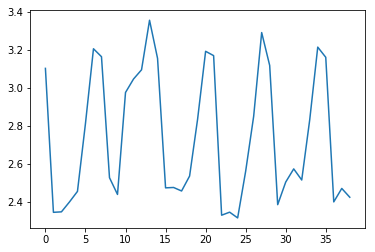

In [28]:
plt.plot(testpreds[129])

In [29]:
preddf=pd.DataFrame(testpreds,index= rrvf_data.idx_to_store(range(testpreds.shape[0]))
                    ,columns= rrvf_data.idx_to_date(range(478,478+39)))
preddf=preddf.unstack().reset_index()
preddf.columns=['date','store','transformed_visitors']
preddf['id']=preddf[['store','date']].apply(lambda u: "_".join(u.values),axis=1)
preddf['visitors']=np.expm1(preddf['transformed_visitors'])
preddf=preddf.set_index(preddf['id'])
preddf.shape

(32331, 5)

In [30]:
preddf.head()

date                 store  \
id                                                                  
air_00a91d42b08b08d9_2017-04-23  2017-04-23  air_00a91d42b08b08d9   
air_0164b9927d20bcc3_2017-04-23  2017-04-23  air_0164b9927d20bcc3   
air_0241aa3964b7f861_2017-04-23  2017-04-23  air_0241aa3964b7f861   
air_0328696196e46f18_2017-04-23  2017-04-23  air_0328696196e46f18   
air_034a3d5b40d5b1b1_2017-04-23  2017-04-23  air_034a3d5b40d5b1b1   

                                 transformed_visitors  \
id                                                      
air_00a91d42b08b08d9_2017-04-23              1.847480   
air_0164b9927d20bcc3_2017-04-23              1.446273   
air_0241aa3964b7f861_2017-04-23              2.401576   
air_0328696196e46f18_2017-04-23              2.157090   
air_034a3d5b40d5b1b1_2017-04-23              3.493566   

                                                              id   visitors  
id                                                                           
air_00a91d42b08b08d9_2017-04-23  air_00a91d42b08b08d9_2017-04-23   5.343814  
air_0164b9927d20bcc3_2017-04-23  air_0164b9927d20bcc3_2017-04-23   3.247255  
air_0241aa3964b7f861_2017-04-23  air_0241aa3964b7f861_2017-04-23  10.040565  
air_0328696196e46f18_2017-04-23  air_0328696196e46f18_2017-04-23   7.645944  
air_034a3d5b40d5b1b1_2017-04-23  air_034a3d5b40d5b1b1_2017-04-23  31.903079

In [31]:
sample=pd.read_csv("../input/sample_submission.csv")
sample.shape

(32019, 2)

In [32]:
submission=preddf[['visitors']].loc[sample['id']]
submission.shape

(32019, 1)

In [33]:
submission.to_csv("../submission/l2_3003_conv_fold{}_{}_d{}.csv.gz".format(j, EXCLUDE_HARD, PRED_DATE)
                  ,compression='gzip')